<a href="https://colab.research.google.com/github/rahiakela/tensorflow-computer-vision-cookbook/blob/main/09-localizing-elements-in-images-with-object-detection/02_detecting_objects_with_yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detecting objects with YOLOv3

Object detection is one of the most common yet challenging tasks in computer vision. It's a natural evolution of image classification, where our goal is to work out what is in an image. On the other hand, object detection is not only concerned with the content of an image but also with the location of elements of interest in a digital image.

As with many other well-known tasks in computer vision, object detection has long been addressed with a wide array of techniques, ranging from naïve solutions (such as object matching) to machine learning-based ones (such as Haar Cascades). Nonetheless, the most effective detectors nowadays are powered by deep learning.

Implementing state-of-the-art object detectors (such as You Only Look Once (YOLO) and Fast Region-based Convolutional Neural Network (Fast R-CNN) from scratch is a very challenging task. However, there are many pre-trained solutions we can leverage, not only to make predictions but also to train our own models from zero.

## Setup

In [26]:
import glob
import json
import struct

import cv2
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, LeakyReLU, Add, Input, UpSampling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [29]:
%%shell

wget -q https://github.com/rahiakela/tensorflow-computer-vision-cookbook/raw/main/09-localizing-elements-in-images-with-object-detection/images/dog.jpg
wget -q https://github.com/rahiakela/tensorflow-computer-vision-cookbook/raw/main/09-localizing-elements-in-images-with-object-detection/images/cars.jpg

wget -q https://pjreddie.com/media/files/yolov3.weights
wget -q https://github.com/rahiakela/tensorflow-computer-vision-cookbook/raw/main/09-localizing-elements-in-images-with-object-detection/resources/coco_labels.txt
wget -q https://github.com/rahiakela/tensorflow-computer-vision-cookbook/raw/main/09-localizing-elements-in-images-with-object-detection/resources/anchors.json

mkdir resources
mkdir test_images
mv yolov3.weights resources/
mv coco_labels.txt resources/
mv anchors.json resources/
mv *.jpg test_images/

mkdir: cannot create directory ‘test_images’: File exists


##Overview

We learned how to turn any image classifier into an object detector, by embedding it in a traditional framework that relies on image pyramids and sliding windows. However, we also learned that this approach isn't ideal because it doesn't allow the network to learn from its mistakes.

The reason why deep learning has conquered the field of object detection is due to its end-to-end approach. The network not only figures out how to classify an object, but also discovers how to produce the best bounding box possible to locate each element in the image.

On top of this, thanks to this end-to-end strategy, a network can detect a myriad objects in a single pass! Of course, this makes such object detectors incredibly efficient!

One of the seminal end-to-end object detectors is YOLO, and in this recipe, we'll learn how to detect objects with a pre-trained YOLOv3 model.

Our implementation is heavily inspired by the amazing keras-yolo3 repository
implemented by Huynh Ngoc Anh:

https://github.com/experiencor/keras-yolo3

Because we'll use a pre-trained YOLO model, we need to download the weights. They're available here: https://pjreddie.com/media/files/yolov3.weights.


## Defining YOLO weights loader class

We will define a `WeightReader()` class that automatically loads the YOLO weights in whichever format the original authors used. Notice that this is a very low-level solution, but we don't need to understand it fully in order to leverage it.

In [3]:
class WeightReader:

  def __init__(self, weight_file):

    with open(weight_file, "rb") as w_f:
      major, = struct.unpack("i", w_f.read(4))
      minor, = struct.unpack("i", w_f.read(4))
      revision, = struct.unpack("i", w_f.read(4))

      if (major * 10 + minor) >= 2 and major < 1000 and minor < 1000:
        w_f.read(8)
      else:
        w_f.read(4)

      binary = w_f.read()

    self.offset = 0
    self.all_weights = np.frombuffer(binary, dtype="float32") 

  def read_bytes(self, size):
    """
    a method to read a given number of bytes from the weights file
    """
    self.offset = self.offset + size

    return self.all_weights[self.offset - size: self.offset]

  def load_weights(self, model):
    """
    This method loads the weights for each of the 106 layers that comprise the YOLO architecture
    """
    for i in tqdm.tqdm(range(106)):
      try:
        conv_layer = model.get_layer(f"conv_{i}")

        if i not in [81, 93, 105]:
          norm_layer = model.get_layer(f"bnorm_{i}")
          size = np.prod(norm_layer.get_weights()[0].shape)
          bias = self.read_bytes(size)
          scale = self.read_bytes(size)
          mean = self.read_bytes(size)
          var = self.read_bytes(size)

          norm_layer.set_weights([scale, bias, mean, var])

        if len(conv_layer.get_weights()) > 1:
          bias = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
          kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2, 3, 1, 0])

          conv_layer.set_weights([kernel, bias])
        else:
          kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))

          kernel = kernel.transpose([2, 3, 1, 0])
          conv_layer.set_weights([kernel])
      except ValueError:
        pass

    
  def reset(self):
    self.offset = 0

Let's define a `BoundBox()` class that encapsulates the vertices of a bounding box, along with the confidence that the enclosed elements are an object (objness).

In [4]:
class BoundBox(object):

  def __init__(self, x_min, y_min, x_max, y_max, objness=None, classes=None):
    self.xmin = x_min
    self.ymin = y_min
    self.xmax = x_max
    self.ymax = y_max
    self.objness = objness
    self.classes = classes
    self.label = -1
    self.score = -1

  def get_label(self):
    if self.label == -1:
      self.label = np.argmax(self.classes)

    return self.label

  def get_score(self):
    if self.score == -1:
      self.score = self.classes[self.get_label()]

    return self.score

Finally, let's define a `YOLO()` class that encapsulates both the construction of the network and the detection logic.

In [27]:
class YOLO(object):
    def __init__(self, weights_path,
                 anchors_path='resources/anchors.json',
                 labels_path='resources/coco_labels.txt',
                 class_threshold=0.65):
        self.weights_path = weights_path
        self.model = self._load_yolo()

        self.labels = []
        with open(labels_path, 'r') as f:
            for l in f:
                self.labels.append(l.strip())

        with open(anchors_path, 'r') as f:
            self.anchors = json.load(f)

        self.class_threshold = class_threshold

    def _conv_block(self, input, convolutions, skip=True):
        x = input
        count = 0
        for conv in convolutions:
            if count == (len(convolutions) - 2) and skip:
                skip_connection = x

            count += 1

            if conv['stride'] > 1:
                x = ZeroPadding2D(((1, 0), (1, 0)))(x)

            x = Conv2D(conv['filter'],
                       conv['kernel'],
                       strides=conv['stride'],
                       padding=('valid' if conv['stride'] > 1
                                else 'same'),
                       name=f'conv_{conv["layer_idx"]}',
                       use_bias=(False if conv['bnorm']
                                 else True))(x)

            if conv['bnorm']:
                name = f'bnorm_{conv["layer_idx"]}'
                x = BatchNormalization(epsilon=1e-3,
                                       name=name)(x)
            if conv['leaky']:
                name = f'leaky_{conv["layer_idx"]}'
                x = LeakyReLU(alpha=0.1, name=name)(x)

        return Add()([skip_connection, x]) if skip else x

    def _make_yolov3_architecture(self):
        input_image = Input(shape=(None, None, 3))

        # Layer  0 => 4
        x = self._conv_block(input_image, [
            {'filter': 32, 'kernel': 3, 'stride': 1,
             'bnorm': True,
             'leaky': True, 'layer_idx': 0},
            {'filter': 64, 'kernel': 3, 'stride': 2,
             'bnorm': True,
             'leaky': True, 'layer_idx': 1},
            {'filter': 32, 'kernel': 1, 'stride': 1,
             'bnorm': True,
             'leaky': True, 'layer_idx': 2},
            {'filter': 64, 'kernel': 3, 'stride': 1,
             'bnorm': True,
             'leaky': True, 'layer_idx': 3}])

        # Layer  5 => 8
        x = self._conv_block(x, [
            {'filter': 128, 'kernel': 3, 'stride': 2,
             'bnorm': True, 'leaky': True, 'layer_idx': 5},
            {'filter': 64, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 6},
            {'filter': 128, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 7}])

        # Layer  9 => 11
        x = self._conv_block(x, [
            {'filter': 64, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 9},
            {'filter': 128, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 10}])

        # Layer 12 => 15
        x = self._conv_block(x, [
            {'filter': 256, 'kernel': 3, 'stride': 2,
             'bnorm': True, 'leaky': True, 'layer_idx': 12},
            {'filter': 128, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 13},
            {'filter': 256, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 14}])

        # Layer 16 => 36
        for i in range(7):
            x = self._conv_block(x, [
                {'filter': 128, 'kernel': 1, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 16 + i * 3},
                {'filter': 256, 'kernel': 3, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 17 + i * 3}])
        skip_36 = x

        # Layer 37 => 40
        x = self._conv_block(x, [
            {'filter': 512, 'kernel': 3, 'stride': 2,
             'bnorm': True, 'leaky': True, 'layer_idx': 37},
            {'filter': 256, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 38},
            {'filter': 512, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 39}])

        # Layer 41 => 61
        for i in range(7):
            x = self._conv_block(x, [
                {'filter': 256, 'kernel': 1, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 41 + i * 3},
                {'filter': 512, 'kernel': 3, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 42 + i * 3}])
        skip_61 = x

        # Layer 62 => 65
        x = self._conv_block(x, [
            {'filter': 1024, 'kernel': 3, 'stride': 2,
             'bnorm': True, 'leaky': True, 'layer_idx': 62},
            {'filter': 512, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 63},
            {'filter': 1024, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 64}])

        # Layer 66 => 74
        for i in range(3):
            x = self._conv_block(x, [
                {'filter': 512, 'kernel': 1, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 66 + i * 3},
                {'filter': 1024, 'kernel': 3, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 67 + i * 3}])

        # Layer 75 => 79
        x = self._conv_block(x, [
            {'filter': 512, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 75},
            {'filter': 1024, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 76},
            {'filter': 512, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 77},
            {'filter': 1024, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 78},
            {'filter': 512, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 79}],
                             skip=False)

        # Layer 80 => 82
        yolo_82 = self._conv_block(x, [
            {'filter': 1024, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 80},
            {'filter': 255, 'kernel': 1, 'stride': 1,
             'bnorm': False, 'leaky': False,
             'layer_idx': 81}], skip=False)

        # Layer 83 => 86
        x = self._conv_block(x, [
            {'filter': 256, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 84}],
                             skip=False)
        x = UpSampling2D(2)(x)
        x = Concatenate()([x, skip_61])

        # Layer 87 => 91
        x = self._conv_block(x, [
            {'filter': 256, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 87},
            {'filter': 512, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 88},
            {'filter': 256, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 89},
            {'filter': 512, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 90},
            {'filter': 256, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 91}],
                             skip=False)
        # Layer 92 => 94
        yolo_94 = self._conv_block(x, [
            {'filter': 512, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 92},
            {'filter': 255, 'kernel': 1, 'stride': 1,
             'bnorm': False, 'leaky': False,
             'layer_idx': 93}], skip=False)

        # Layer 95 => 98
        x = self._conv_block(x, [
            {'filter': 128, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 96}],
                             skip=False)
        x = UpSampling2D(2)(x)
        x = Concatenate()([x, skip_36])

        # Layer 99 => 106
        yolo_106 = self._conv_block(x, [
            {'filter': 128, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 99},
            {'filter': 256, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 100},
            {'filter': 128, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 101},
            {'filter': 256, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 102},
            {'filter': 128, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 103},
            {'filter': 256, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 104},
            {'filter': 255, 'kernel': 1, 'stride': 1,
             'bnorm': False, 'leaky': False,
             'layer_idx': 105}], skip=False)

        return Model(inputs=input_image,
                     outputs=[yolo_82, yolo_94, yolo_106])

    def _load_yolo(self):
        model = self._make_yolov3_architecture()
        weight_reader = WeightReader(self.weights_path)
        weight_reader.load_weights(model)
        model.save('model.h5')

        model = load_model('model.h5')

        return model

    @staticmethod
    def _sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    def _decode_net_output(self, network_output,
                           anchors,
                           obj_thresh,
                           network_height,
                           network_width):
        grid_height, grid_width = network_output.shape[:2]
        nb_box = 3
        network_output = network_output.reshape(
            (grid_height, grid_width, nb_box, -1))

        boxes = []
        network_output[..., :2] = \
            self._sigmoid(network_output[..., :2])
        network_output[..., 4:] = \
            self._sigmoid(network_output[..., 4:])
        network_output[..., 5:] = \
            (network_output[..., 4][..., np.newaxis] *
             network_output[..., 5:])
        network_output[..., 5:] *= \
            network_output[..., 5:] > obj_thresh

        for i in range(grid_height * grid_width):
            r = i / grid_width
            c = i % grid_width

            for b in range(nb_box):
                objectness = \
                    network_output[int(r)][int(c)][b][4]

                if objectness.all() <= obj_thresh:
                    continue

                x, y, w, h = \
                    network_output[int(r)][int(c)][b][:4]
                x = (c + x) / grid_width
                y = (r + y) / grid_height
                w = (anchors[2 * b] * np.exp(w) /
                     network_width)
                h = (anchors[2 * b + 1] * np.exp(h) /
                     network_height)

                classes = network_output[int(r)][c][b][5:]
                box = BoundBox(x_min=x - w / 2,
                               y_min=y - h / 2,
                               x_max=x + w / 2,
                               y_max=y + h / 2,
                               objness=objectness,
                               classes=classes)
                boxes.append(box)

        return boxes

    @staticmethod
    def _correct_yolo_boxes(boxes,
                            image_height,
                            image_width,
                            network_height,
                            network_width):
        new_w, new_h = network_width, network_height

        for i in range(len(boxes)):
            x_offset = (network_width - new_w) / 2.0
            x_offset /= network_width
            x_scale = float(new_w) / network_width

            y_offset = (network_height - new_h) / 2.0
            y_offset /= network_height
            y_scale = float(new_h) / network_height

            boxes[i].xmin = int((boxes[i].xmin - x_offset) /
                                x_scale * image_width)
            boxes[i].xmax = int((boxes[i].xmax - x_offset) /
                                x_scale * image_width)
            boxes[i].ymin = int((boxes[i].ymin - y_offset) /
                                y_scale * image_height)
            boxes[i].ymax = int((boxes[i].ymax - y_offset) /
                                y_scale * image_height)

    @staticmethod
    def _interval_overlap(interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b

        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2, x4) - x1
        else:
            if x2 < x3:
                return 0
            else:
                return min(x2, x4) - x3

    def _bbox_iou(self, box1, box2):
        intersect_w = self._interval_overlap(
            [box1.xmin, box1.xmax],
            [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap(
            [box1.ymin, box1.ymax],
            [box2.ymin, box2.ymax])

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
        w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

        union = w1 * h1 + w2 * h2 - intersect
        return float(intersect) / union

    def _non_max_suppression(self, boxes, nms_thresh):
        if len(boxes) > 0:
            nb_class = len(boxes[0].classes)
        else:
            return

        for c in range(nb_class):
            sorted_indices = np.argsort(
                [-box.classes[c] for box in boxes])

            for i in range(len(sorted_indices)):
                index_i = sorted_indices[i]

                if boxes[index_i].classes[c] == 0:
                    continue

                for j in range(i + 1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    iou = self._bbox_iou(boxes[index_i],
                                         boxes[index_j])
                    if iou >= nms_thresh:
                        boxes[index_j].classes[c] = 0

    def _get_boxes(self, boxes):
        v_boxes, v_labels, v_scores = [], [], []

        for box in boxes:
            for i in range(len(self.labels)):
                if box.classes[i] > self.class_threshold:
                    v_boxes.append(box)
                    v_labels.append(self.labels[i])
                    v_scores.append(box.classes[i] * 100)

        return v_boxes, v_labels, v_scores

    @staticmethod
    def _draw_boxes(filename, v_boxes, v_labels, v_scores):
        data = plt.imread(filename)
        plt.imshow(data)

        ax = plt.gca()

        for i in range(len(v_boxes)):
            box = v_boxes[i]

            y1, x1, y2, x2 = \
                box.ymin, box.xmin, box.ymax, box.xmax

            width = x2 - x1
            height = y2 - y1

            rectangle = Rectangle((x1, y1), width, height,
                                  fill=False, color='white')

            ax.add_patch(rectangle)
            label = f'{v_labels[i]} ({v_scores[i]:.3f})'
            plt.text(x1, y1, label, color='yellow')
        plt.show()

    def detect(self, image, width, height):
        image = np.expand_dims(image, axis=0)
        preds = self.model.predict(image)

        boxes = []

        for i in range(len(preds)):
            boxes.extend(
                self._decode_net_output(preds[i][0],
                                        self.anchors[i],
                                        self.class_threshold,
                                        416,
                                        416))

        self._correct_yolo_boxes(boxes, height, width, 416,
                                 416)
        self._non_max_suppression(boxes, .5)

        valid_boxes, valid_labels, valid_scores = \
            self._get_boxes(boxes)

        for i in range(len(valid_boxes)):
            print(valid_labels[i], valid_scores[i])

        self._draw_boxes(image_path,
                         valid_boxes,
                         valid_labels,
                         valid_scores)

##Create YOLO model

With the YOLO() class defined, we can instantiate it as follows:

In [ ]:
model = YOLO(weights_path="resources/yolov3.weights")

## Making prediction

The final step is to iterate over all test images and run the model on them.

car 99.89618062973022
car 99.73328709602356
person 97.55167365074158
person 97.97220230102539
car 65.21438956260681
car 97.17356562614441
person 86.06638312339783
person 76.2372076511383
car 69.58919763565063
car 67.44755506515503
person 84.91389155387878
person 80.60295581817627
car 77.48515605926514


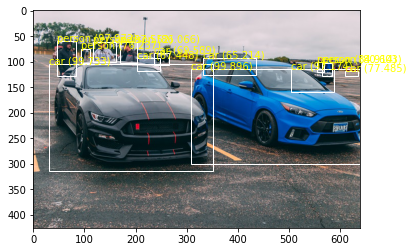

dog 94.49598789215088


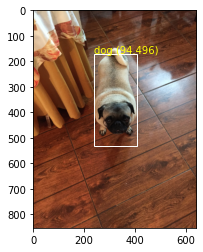

In [31]:
for image_path in glob.glob('test_images/*.jpg'):
  image = load_img(image_path, target_size=(416, 416))
  image = img_to_array(image)
  image = image.astype('float32') / 255.0

  original_image = load_img(image_path)
  width, height = original_image.size

  model.detect(image, width, height)

We can observe that YOLO confidently detected my dog as such, with a confidence
score of 94.5%! Awesome!

##Take aways

Although YOLO was originally implemented in C++, we leveraged the fantastic Python
adaptation by Huynh Ngoc Anh to perform object detection in our own images using
a pre-trained version (specifically, version 3) of this architecture on the seminal COCO
dataset.

As you might have noticed, YOLO and many other end-to-end object detectors are
very complex networks, but their advantage over traditional approaches such as image
pyramids and sliding windows is evident. Not only are the results way better, but they
also come through faster thanks to the ability of YOLO to look once at the input image in
order to produce all the relevant detections.

But what if you want to train an end-to-end object detector on your own data? Are you
doomed to rely on out-of-the-box solutions? Do you need to spend hours deciphering
cryptic papers in order to implement such networks?

Well, that's one option, but there's another one, which we'll explore in the next recipe, and
it entails the TensorFlow Object Detection API, an experimental repository of state-ofthe-
art architectures that will ease and boost your object detection endeavors!